In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import mne
import plotly.graph_objects as go
from scipy.io import loadmat
from scipy.signal import welch, butter, filtfilt
from sklearn.svm import SVC
from sklearn.decomposition import FastICA, PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from collections import defaultdict
from xgboost import XGBClassifier
from matplotlib import cm
from mne.viz import plot_topomap
from sklearn.model_selection import GroupKFold, cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)



In [22]:
eeg_bands = {
    'theta': (4, 7),
    'alpha': (8, 13),
    'beta': (14, 29),
    'gamma': (30, 47)
}

EPSILON = 1e-10

In [23]:
def load_eeg_data(data_root='Data'):
    all_data = {}

    for subject_num in range(1, 6):
        subject_name = f"Subject_{subject_num}"
        subject_folder = os.path.join(data_root, subject_name)
        all_data[subject_name] = {'eyes_open': {}, 'eyes_closed': {}}

        for condition in ['eyes_open', 'eyes_closed']:
            condition_folder = os.path.join(subject_folder, condition)
            file_prefix = 'O' if condition == 'eyes_open' else 'C'

            for odor_num in range(1, 5):
                file_name = f"{file_prefix}_{odor_num}.mat"
                full_path = os.path.join(condition_folder, file_name)

                if os.path.exists(full_path):
                    try:
                        mat = loadmat(full_path)
                        all_data[subject_name][condition][f'odor_{odor_num}'] = {
                            'baseline': mat.get('baseline'),
                            'X_event': mat.get('X_event')
                        }
                    except:
                        continue  # silently skip unreadable files

    return all_data


In [24]:
eeg_dataset = load_eeg_data("Data")

In [25]:
def count_loaded_files(eeg_dataset):
    count = 0
    for conditions in eeg_dataset.values():
        for odors in conditions.values():
            count += sum(1 for data in odors.values() if data is not None)
    return count

print(f"Total loaded files: {count_loaded_files(eeg_dataset)}")


Total loaded files: 40


In [26]:
# Example: Access Subject_1 eyes_open odor_1
sample = eeg_dataset.get('Subject_1', {}).get('eyes_open', {}).get('odor_1')
if sample:
    print("Baseline shape:", sample['baseline'].shape)
    print("X_event shape:", sample['X_event'].shape)
    print("First few baseline values:\n", sample['baseline'].flatten()[:3])

Baseline shape: (250, 216, 18)
X_event shape: (250, 216, 18)
First few baseline values:
 [-0.79959888  1.41107278 -0.42808102]


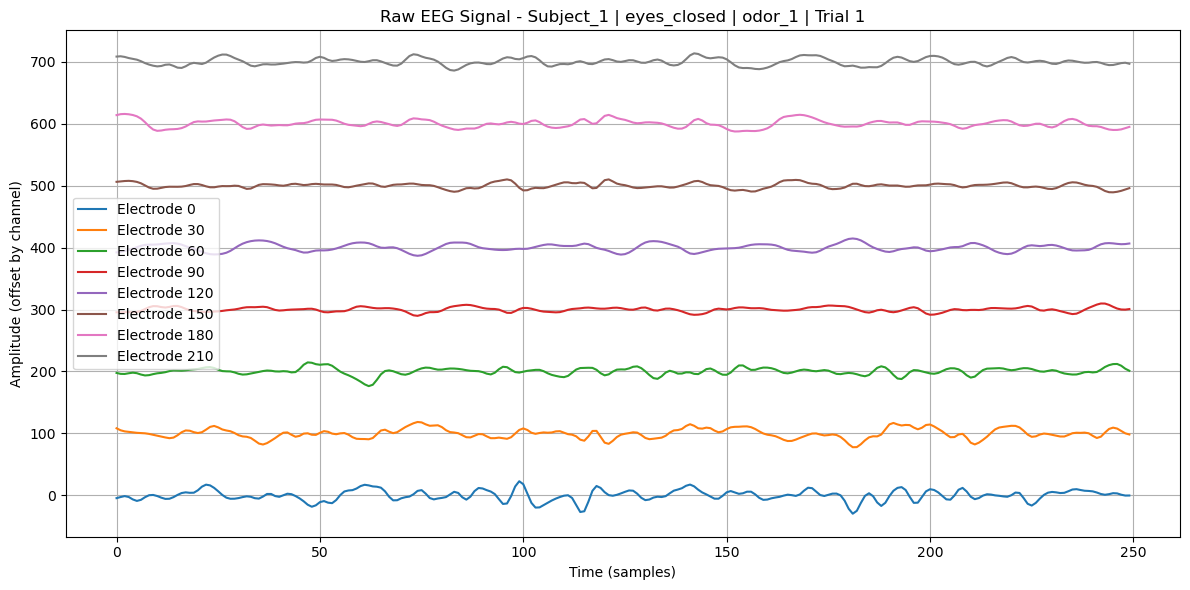

In [27]:
subject = "Subject_1"
condition = "eyes_closed"
odor = "odor_1"

X_event = eeg_dataset[subject][condition][odor]['X_event']

# Pick one trial and a few electrodes (e.g., 8 out of 216)
trial_idx = 0
electrode_indices = [0, 30, 60, 90, 120, 150, 180, 210]  # arbitrary electrode positions to visualize

# Plot
plt.figure(figsize=(12, 6))
for i, ch in enumerate(electrode_indices):
    signal = X_event[:, ch, trial_idx]
    plt.plot(signal + i * 100, label=f'Electrode {ch}')  # offset for visibility

plt.title(f'Raw EEG Signal - {subject} | {condition} | {odor} | Trial {trial_idx+1}')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude (offset by channel)')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


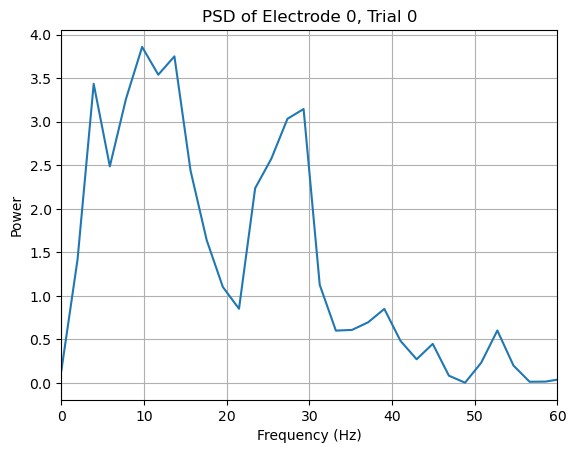

In [28]:
# Visualize PSD for electrode 0
f, Pxx = welch(X_event[:, 0, 0], fs=250, nperseg=128)
plt.plot(f, Pxx)
plt.title('PSD of Electrode 0, Trial 0')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.grid(True)
plt.xlim(0, 60)
plt.show()

In [29]:
best_worst_map = {
    'Subject_1': {'eyes_open': {'best': 4, 'worst': 3}, 'eyes_closed': {'best': 2, 'worst': 1}},
    'Subject_2': {'eyes_open': {'best': 4, 'worst': 3}, 'eyes_closed': {'best': 1, 'worst': 2}},
    'Subject_3': {'eyes_open': {'best': 2, 'worst': 1}, 'eyes_closed': {'best': 4, 'worst': 2}},
    'Subject_4': {'eyes_open': {'best': 1, 'worst': 4}, 'eyes_closed': {'best': 4, 'worst': 3}},
    'Subject_5': {'eyes_open': {'best': 4, 'worst': 3}, 'eyes_closed': {'best': 3, 'worst': 1}},
}

In [30]:
from scipy.stats import binomtest

objective_valence = {
    1: 0,  # valerian
    2: 1,  # lotus
    3: 0,  # cheese
    4: 1   # rosewater
}

total = 0
agree = 0

for subject, cond_dict in best_worst_map.items():
    for condition, ratings in cond_dict.items():
        best_odor = ratings["best"]
        worst_odor = ratings["worst"]
        
        if objective_valence.get(best_odor) == 1:
            agree += 1

        if objective_valence.get(worst_odor) == 0:
            agree += 1
        
        total += 2  

agreement_rate = agree / total
print(f"Subjective-Objective Agreement Rate: {agree}/{total} = {agreement_rate:.2%}")

result = binomtest(agree, total, p=0.5, alternative='greater')
print(f"Binomial Test p-value: {result.pvalue:.4f}")


Subjective-Objective Agreement Rate: 14/20 = 70.00%
Binomial Test p-value: 0.0577


In [ ]:
# There is some alignment between what subjects rated as pleasant/unpleasant and what is objectively pleasant/unpleasant.
# However, the result is not statistically significant (p~0.05).
# This suggests individual preferences may diverge from traditional expectation.

In [31]:
agreement_by_condition = {"eyes_open": {"agree": 0, "total": 0},
                          "eyes_closed": {"agree": 0, "total": 0}}

for subject, conds in best_worst_map.items():
    for condition in ["eyes_open", "eyes_closed"]:
        best = conds[condition]["best"]
        worst = conds[condition]["worst"]

        if objective_valence[best] == 1:
            agreement_by_condition[condition]["agree"] += 1
  
        if objective_valence[worst] == 0:
            agreement_by_condition[condition]["agree"] += 1

        agreement_by_condition[condition]["total"] += 2

for condition in ["eyes_open", "eyes_closed"]:
    agree = agreement_by_condition[condition]["agree"]
    total = agreement_by_condition[condition]["total"]
    rate = agree / total
    p_value = binomtest(agree, total, p=0.5, alternative='greater').pvalue

    print(f" {condition.capitalize()} - Agreement Rate: {rate:.0%} ({agree}/{total})")
    print(f"   Binomial Test p-value: {p_value:.4f}")


 Eyes_open - Agreement Rate: 80% (8/10)
   Binomial Test p-value: 0.0547
 Eyes_closed - Agreement Rate: 60% (6/10)
   Binomial Test p-value: 0.3770


In [ ]:
# Subjects are more likely to agree with the traditional (objective) odor lables when their eyes are open.
# This supports the idea that sensory and cognitive context (visual) influences how we evaluate smells (might be due to placebo).

In [32]:
consistency_results = []

for subject, conds in best_worst_map.items():
    best_open = conds['eyes_open']['best']
    best_closed = conds['eyes_closed']['best']
    worst_open = conds['eyes_open']['worst']
    worst_closed = conds['eyes_closed']['worst']

    consistency_results.append({
        "subject": subject,
        "best_open": best_open,
        "best_closed": best_closed,
        "best_consistent": best_open == best_closed,
        "worst_open": worst_open,
        "worst_closed": worst_closed,
        "worst_consistent": worst_open == worst_closed
    })

consistency_df = pd.DataFrame(consistency_results)
best_consistency_rate = consistency_df["best_consistent"].mean()
worst_consistency_rate = consistency_df["worst_consistent"].mean()

print("Best odor consistency across conditions:", f"{best_consistency_rate:.0%}")
print("Worst odor consistency across conditions:", f"{worst_consistency_rate:.0%}")


Best odor consistency across conditions: 0%
Worst odor consistency across conditions: 0%


In [ ]:
# Striking finding:
# Not a single subject chose the same "best" or "worst" odor under both eyes open and eyes closed conditions.
# Visual state dramatically alters subjective odor perception.
# When eyes are closed, internal processes (i.e., attention, imagination, memory) may play a greater role in shaping experience.
# The neural representations of odor pleasantness may differ not just by person or odor, but also by sensory context.

In [33]:

def highpass_filter(signal, cutoff=3, fs=250, order=3):
    b, a = butter(order, cutoff / (0.5 * fs), btype='high')
    return filtfilt(b, a, signal, axis=0)

def run_ica_on_data(X):
    n_samples, n_channels, n_trials = X.shape
    data_reshaped = X.reshape(-1, n_channels)  # stack all trials
    ica = FastICA(n_components=n_channels, max_iter=500, random_state=42)
    components = ica.fit_transform(data_reshaped)
    cleaned = ica.inverse_transform(components)
    return cleaned.reshape(n_samples, n_channels, n_trials)

# Common average reference
def apply_car(signal):
    return signal - np.mean(signal, axis=1, keepdims=True)

def baseline_correct(X_event, baseline):
    baseline_mean = np.mean(baseline, axis=0)  
    return X_event - baseline_mean[np.newaxis, :, :]  

def preprocess_trials(X_event, baseline, condition):
    X = baseline_correct(X_event, baseline)

    # ICA (only for eyes_open)
    if condition == 'eyes_open':
        X = run_ica_on_data(X)

    X_clean = np.zeros_like(X)
    for i in range(X.shape[2]):
        trial = X[:, :, i]
        trial = highpass_filter(trial)
        trial = apply_car(trial)
        X_clean[:, :, i] = trial

    return X_clean

In [34]:
eeg_cleaned_dataset = {}

for subject, conditions in eeg_dataset.items():
    eeg_cleaned_dataset[subject] = {}
    for condition, odors in conditions.items():
        eeg_cleaned_dataset[subject][condition] = {}
        for odor, signals in odors.items():
            X_event = signals['X_event']
            baseline = signals['baseline']
            if X_event is None or baseline is None:
                continue
            X_clean = preprocess_trials(X_event, baseline, condition)
            eeg_cleaned_dataset[subject][condition][odor] = X_clean

In [35]:
def count_all_trials(eeg_data):
    total = 0
    for subject, conditions in eeg_data.items():
        for condition, odors in conditions.items():
            for odor, data in odors.items():
                if data is not None:
                    n_trials = data.shape[2]
                    print(f"{subject} | {condition} | {odor}  {n_trials} trials")
                    total += n_trials
    print(f"Total trials across dataset: {total}")

count_all_trials(eeg_cleaned_dataset)


Subject_1 | eyes_open | odor_1  18 trials
Subject_1 | eyes_open | odor_2  18 trials
Subject_1 | eyes_open | odor_3  19 trials
Subject_1 | eyes_open | odor_4  21 trials
Subject_1 | eyes_closed | odor_1  17 trials
Subject_1 | eyes_closed | odor_2  18 trials
Subject_1 | eyes_closed | odor_3  21 trials
Subject_1 | eyes_closed | odor_4  20 trials
Subject_2 | eyes_open | odor_1  17 trials
Subject_2 | eyes_open | odor_2  18 trials
Subject_2 | eyes_open | odor_3  19 trials
Subject_2 | eyes_open | odor_4  21 trials
Subject_2 | eyes_closed | odor_1  17 trials
Subject_2 | eyes_closed | odor_2  21 trials
Subject_2 | eyes_closed | odor_3  19 trials
Subject_2 | eyes_closed | odor_4  24 trials
Subject_3 | eyes_open | odor_1  22 trials
Subject_3 | eyes_open | odor_2  23 trials
Subject_3 | eyes_open | odor_3  22 trials
Subject_3 | eyes_open | odor_4  23 trials
Subject_3 | eyes_closed | odor_1  21 trials
Subject_3 | eyes_closed | odor_2  20 trials
Subject_3 | eyes_closed | odor_3  18 trials
Subject_3 | 

In [47]:

def extract_psd_features(X, sfreq=250):
    n_channels = X.shape[1]
    features = []
    for trial in range(X.shape[2]):
        trial_data = X[:, :, trial]  
        psd_feats = []
        for ch in range(n_channels):
            freqs, psd = welch(trial_data[:, ch], sfreq, nperseg=128)
            for band in eeg_bands.values():
                band_power = np.mean(psd[(freqs >= band[0]) & (freqs <= band[1])])
                psd_feats.append(band_power)
        features.append(psd_feats)
    return np.array(features)  
    

def build_cleaned_features(eeg_cleaned_dataset):
    rows = []
    for subject in eeg_cleaned_dataset:
        for condition in ['eyes_open', 'eyes_closed']:
            for odor_key in eeg_cleaned_dataset[subject][condition]:
                odor_num = int(odor_key.split('_')[1]) 
                X_clean = eeg_cleaned_dataset[subject][condition][odor_key]
                if X_clean is None or X_clean.shape[-1] == 0:
                    continue

                feats = extract_psd_features(X_clean, sfreq=sfreq)

                for i in range(feats.shape[0]):
                    y_subj = None
                    y_obj = objective_valence.get(odor_num)

                    subj_map = best_worst_map.get(subject, {}).get(condition, {})
                    if subj_map.get('best') == odor_num:
                        y_subj = 1
                    elif subj_map.get('worst') == odor_num:
                        y_subj = 0

                    rows.append({
                        'subject': subject,
                        'condition': condition,
                        'odor': odor_num,
                        'y_subjective': y_subj,
                        'y_objective': y_obj,
                        'features': feats[i]
                    })

    return pd.DataFrame(rows)

eeg_cleaned_data = build_cleaned_features(eeg_cleaned_dataset)


def decode_multiple_models(eeg_data):
    results = []

    models = {
        'SVC': make_pipeline(StandardScaler(), SVC(kernel='linear')),
        'RandomForest': make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100, random_state=42)),
        'XGBoost': make_pipeline(StandardScaler(), XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
        'LogisticRegression': make_pipeline(StandardScaler(), LogisticRegression(max_iter=500)),
        'KNN': make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5))
    }

    for condition in ['eyes_open', 'eyes_closed']:
        for label_type in ['y_subjective', 'y_objective']:
            df = eeg_data[(eeg_data['condition'] == condition) & (eeg_data[label_type].notna())]

            try:
                X = np.stack(df['features'].values)
                y = df[label_type].astype(int).values

                if len(np.unique(y)) < 2:
                    continue  

                for model_name, model in models.items():
                    acc = cross_val_score(model, X, y, cv=5).mean()
                    results.append({
                        'condition': condition,
                        'label_type': label_type,
                        'model': model_name,
                        'accuracy': acc,
                        'n_trials': len(y)
                    })

            except Exception as e:
                print(f"❌ Error in {condition} - {label_type} - {model_name}: {e}")

    return pd.DataFrame(results)

results_multi_model = decode_multiple_models(eeg_cleaned_data)

pivot_df = results_multi_model.pivot_table(
    index=['condition', 'label_type', 'n_trials'],
    columns='model',
    values='accuracy'
).reset_index()

pivot_df = pivot_df.sort_values(by=['condition', 'label_type'])
print(pivot_df)



/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:40:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:40:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:40:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:40:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

model    condition    label_type  n_trials       KNN  LogisticRegression  \
0      eyes_closed   y_objective       409  0.520626            0.596357   
1      eyes_closed  y_subjective       203  0.447805            0.522195   
2        eyes_open   y_objective       409  0.618308            0.635592   
3        eyes_open  y_subjective       204  0.607317            0.415976   

model  RandomForest       SVC   XGBoost  
0          0.545017  0.589039  0.540139  
1          0.609756  0.532317  0.536341  
2          0.593767  0.655164  0.667148  
3          0.499878  0.450000  0.485488  


In [ ]:
# Strongest ML performance = Eyes Open + Objective (for all models).

# 1. Objective Pleasantness is Much Easier to Decode
# In both eyes open and eyes closed, accuracy for y_objective is consistently (90% of the case) higher across models.
# Best model overall: XGBoost in eyes_open (66.7%), indicating EEG contains information about odor perference.

# 2. Subjective Preferences Are Less Consistent
# Much lower and more variable performance for y_subjective (5/5 <50% are subjective preferences).

# 3. Performance is model-sensitive: RF and KNN show scattered strengths (i.e. KNN best for eyes open, RF best for eyes closed).

# This reflects subjectivity: people disagree with objective odor rating, and neural patterns for preferences are weaker.
# Noted that we have less trials for subjetive data which may impact the results but since all below 50% are from subjective training, the results are still reliable.

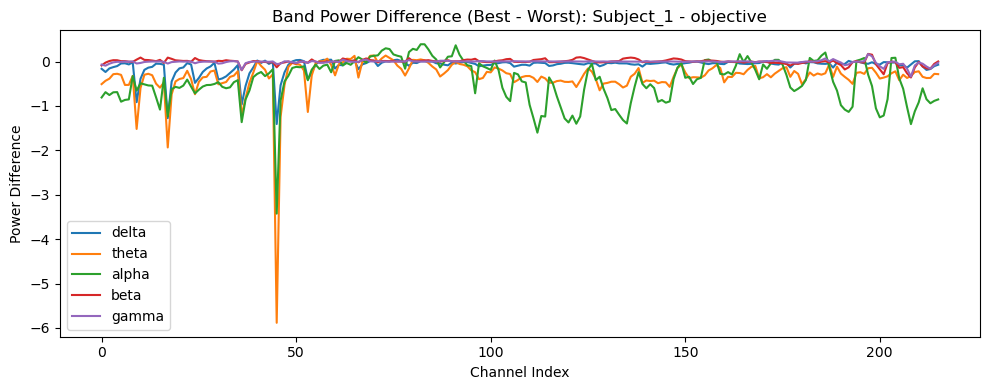

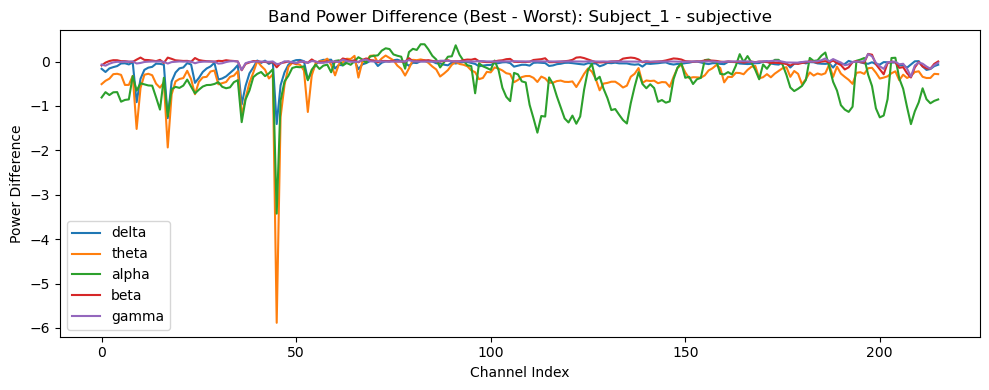

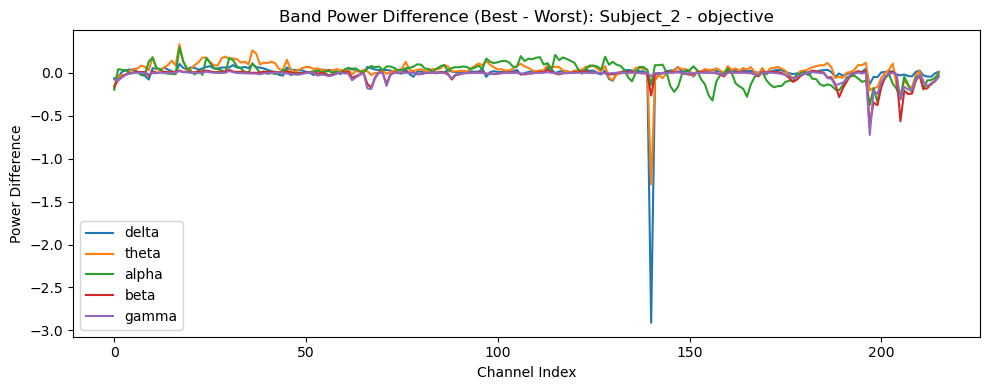

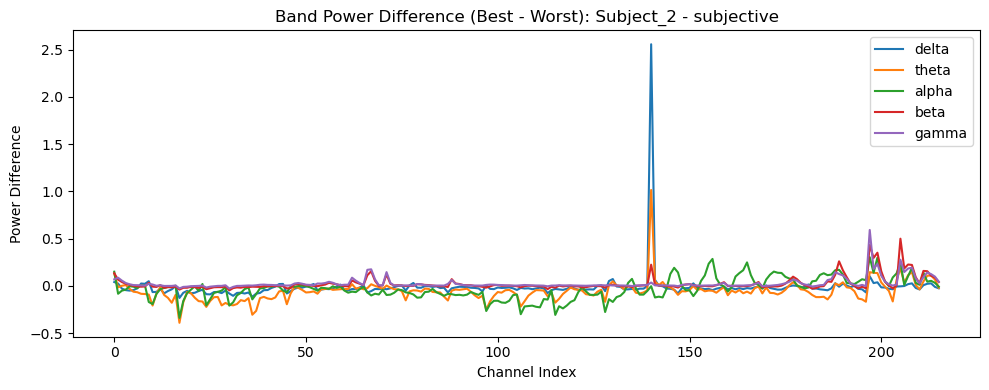

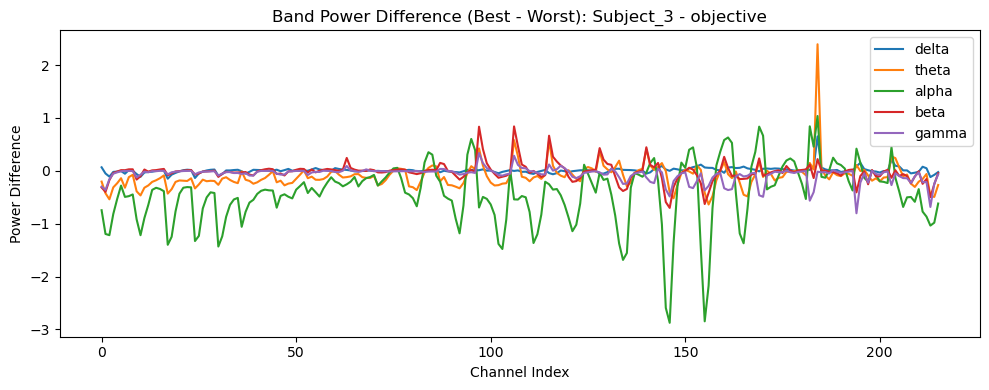

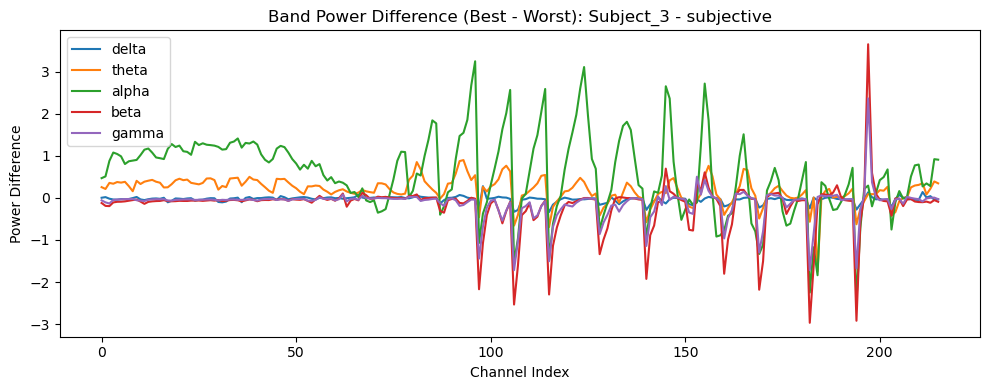

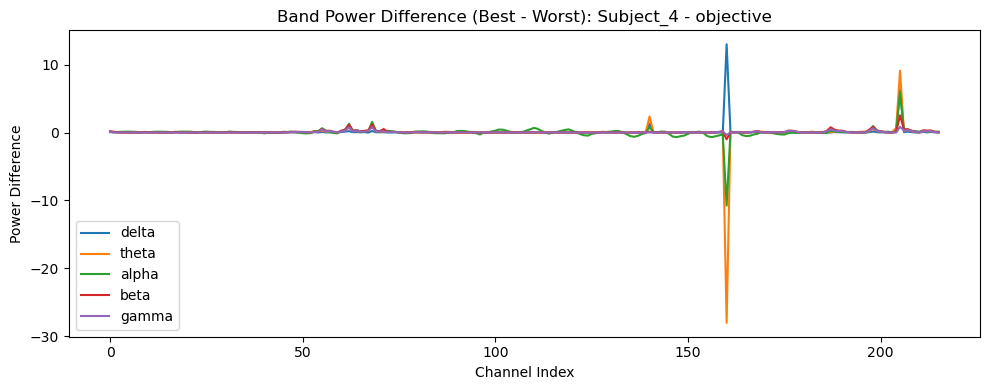

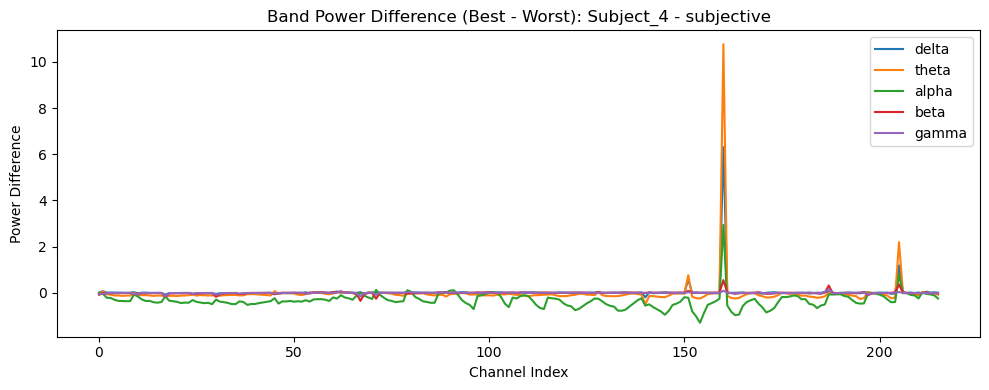

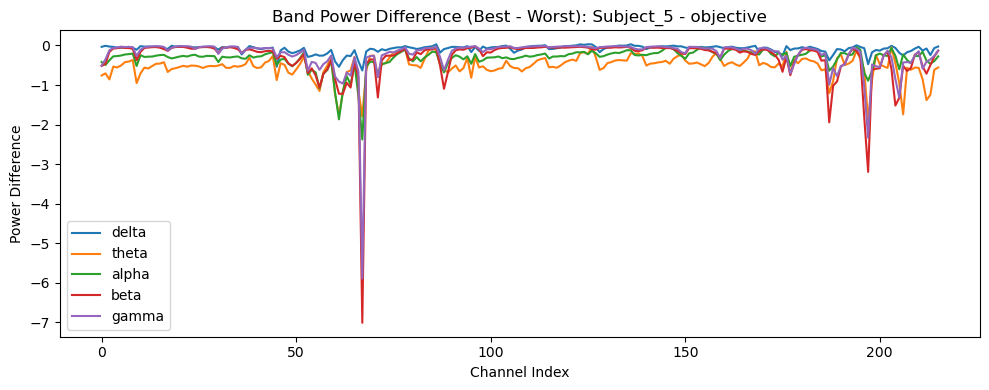

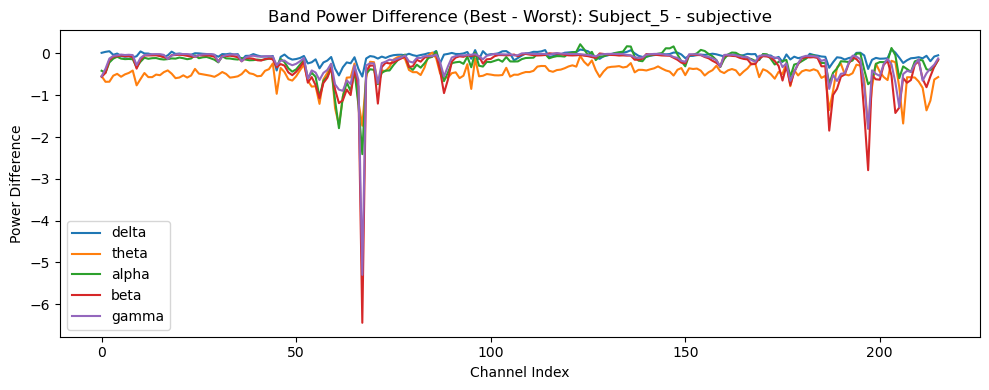

In [84]:
def compute_band_power(X, sfreq=250):
    n_channels = X.shape[1]
    n_trials = X.shape[2]
    band_powers = {band: np.zeros((n_channels, n_trials)) for band in eeg_bands}

    for i in range(n_trials):
        for ch in range(n_channels):
            f, psd = welch(X[:, ch, i], sfreq, nperseg=128)
            for band, (low, high) in eeg_bands.items():
                band_mask = (f >= low) & (f <= high)
                band_powers[band][ch, i] = np.mean(psd[band_mask])
    return band_powers

def average_band_diff(X_best, X_worst):
    power_best = compute_band_power(X_best)
    power_worst = compute_band_power(X_worst)

    band_diffs = {}
    for band in eeg_bands:
        mean_best = np.mean(power_best[band], axis=1)  # avg over trials
        mean_worst = np.mean(power_worst[band], axis=1)
        band_diffs[band] = mean_best - mean_worst
    return band_diffs

def plot_band_diffs(band_diffs, title):
    plt.figure(figsize=(10, 4))
    for i, (band, diff) in enumerate(band_diffs.items()):
        plt.plot(diff, label=band)
    plt.title(f'Band Power Difference (Best - Worst): {title}')
    plt.xlabel('Channel Index')
    plt.ylabel('Power Difference')
    plt.legend()
    plt.tight_layout()
    plt.show()


for subject in eeg_cleaned_dataset:
    for label_type in ['objective', 'subjective']:
        best_odors = []
        worst_odors = []

        for cond in ['eyes_open', 'eyes_closed']:
            best = best_worst_map[subject][cond]['best'] if label_type == 'subjective' else (4 if cond == 'eyes_open' else 2)
            worst = best_worst_map[subject][cond]['worst'] if label_type == 'subjective' else (3 if cond == 'eyes_open' else 1)

            best_X = eeg_cleaned_dataset[subject][cond].get(f'odor_{best}')
            worst_X = eeg_cleaned_dataset[subject][cond].get(f'odor_{worst}')
            if best_X is not None and worst_X is not None:
                best_odors.append(best_X)
                worst_odors.append(worst_X)

        if best_odors and worst_odors:
            X_best = np.concatenate(best_odors, axis=2)
            X_worst = np.concatenate(worst_odors, axis=2)
            band_diffs = average_band_diff(X_best, X_worst)
            plot_band_diffs(band_diffs, title=f"{subject} - {label_type}")

In [ ]:
# (Average band power during Best odor trials) − (Average during Worst odor trials) per channel, for each EEG frequency band (delta → gamma)

# Positive values: more power during Best-rated odors;
# Negative values: more power during Worst-rated odors;
# Spikes: strong per-channel difference in that frequency band (or outliers which can be artifacts).

# Subject 3 - subjective plot
# Clear difference between Best and Worst odors in alpha, beta and theta bands.
# Alpha power increases notably in Best odors, especially across multiple channels.
# Suggests emotional or cognitive engagement differences aligned with subjective experience.
# For subject 3, subjective preferences are reflected in EEG — especially beta/(theta+alpha) - aligns with workload index in kroupi2014 paper.

# Subject 3 - objective plot
# Similar patterns, but weaker and less focused than subjective
# Again, alpha, beta and theta play crucial roles.

/var/folders/2n/_xwr31n93t3f6fgs407r9l2r0000gn/T/ipykernel_9671/3796407125.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 0.93, 0.95])


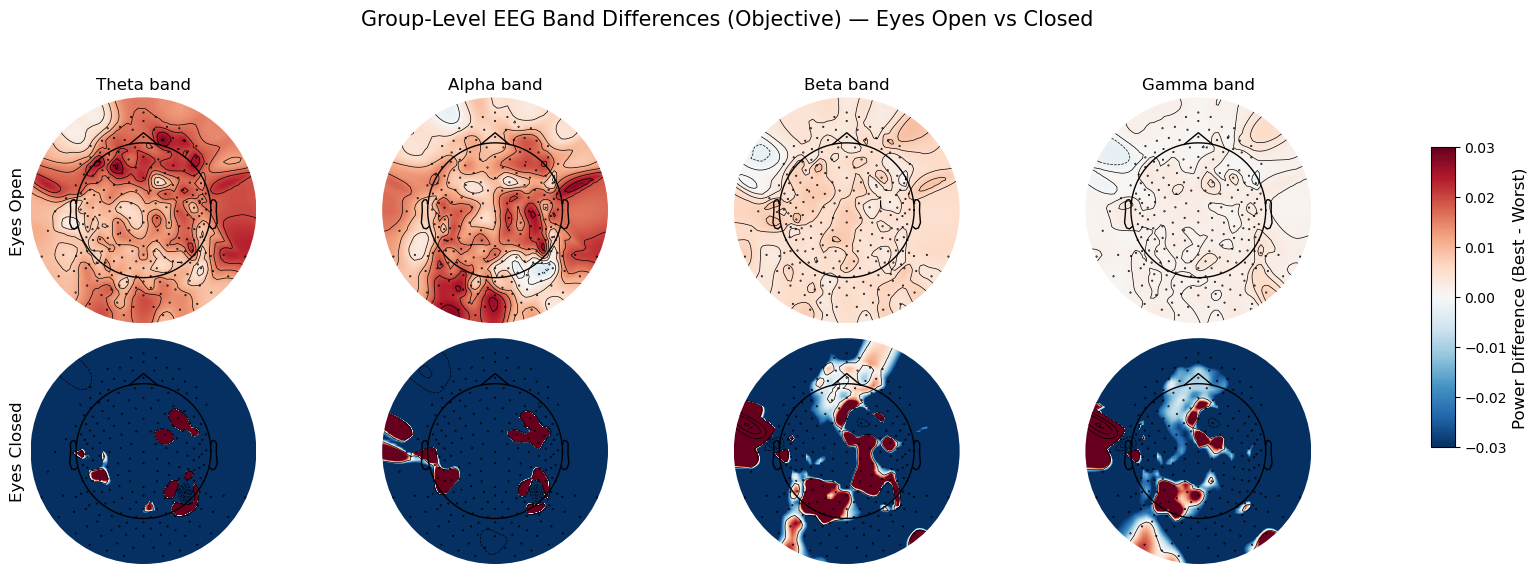

In [70]:
montage = mne.channels.make_standard_montage('GSN-HydroCel-256')
ch_names = montage.ch_names[:216]
ch_pos = {ch: pos[:3] for ch, pos in montage.get_positions()['ch_pos'].items() if ch in ch_names}


info = mne.create_info(ch_names=ch_names, sfreq=250, ch_types='eeg')
info.set_montage(montage)

all_band_maps = {'eyes_open': {}, 'eyes_closed': {}}

for cond in ['eyes_open', 'eyes_closed']:
    group_band_diffs = {band: [] for band in eeg_bands}

    for subject in eeg_cleaned_dataset:

        best = 4 if cond == 'eyes_open' else 2
        worst = 3 if cond == 'eyes_open' else 1

        best_X = eeg_cleaned_dataset[subject][cond].get(f'odor_{best}')
        worst_X = eeg_cleaned_dataset[subject][cond].get(f'odor_{worst}')

        if best_X is not None and worst_X is not None:
            band_best = compute_band_power(best_X)
            band_worst = compute_band_power(worst_X)

            for band in eeg_bands:
                mean_best = np.mean(band_best[band], axis=1)
                mean_worst = np.mean(band_worst[band], axis=1)
                diff = mean_best - mean_worst
                group_band_diffs[band].append(diff)

    avg_band_maps = {
        band: np.mean(group_band_diffs[band], axis=0) for band in eeg_bands
    }
    all_band_maps[cond] = avg_band_maps


fig, axes = plt.subplots(2, 4, figsize=(16, 6))
bands = ['theta', 'alpha', 'beta', 'gamma']
conditions = ['eyes_open', 'eyes_closed']

vlim_fixed = 0.03  

for row_idx, cond in enumerate(conditions):
    for col_idx, band in enumerate(bands):
        ax = axes[row_idx, col_idx]
        data = all_band_maps[cond][band]

        im, _ = plot_topomap(
            data,
            pos=info,
            axes=ax,
            show=False,
            cmap='RdBu_r',
            vlim=(-vlim_fixed, vlim_fixed),
            contours=6,
            sphere=0.07,
        )

        if row_idx == 0:
            ax.set_title(f'{band.capitalize()} band', fontsize=12)
        if col_idx == 0:
            ax.set_ylabel('Eyes Open' if cond == 'eyes_open' else 'Eyes Closed', fontsize=12)


fig.subplots_adjust(right=0.92)
cbar_ax = fig.add_axes([0.94, 0.25, 0.015, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Power Difference (Best - Worst)', fontsize=12)

fig.suptitle('Group-Level EEG Band Differences (Objective) — Eyes Open vs Closed', fontsize=15)
plt.tight_layout(rect=[0, 0.03, 0.93, 0.95])
plt.show()

In [ ]:
# Average EEG scalp map of power change per band, across all subjects (objectively labeled).

# Warm colors (red) = higher power for pleasant (best) odors
# Cool colors (blue) = higher power for unpleasant (worst) odors

# Objective Eyes Open (strongest ML results):
# Theta: Broad frontal and parietal increases. Possibly reflects emotional engagement or cognitive attention to pleasant odors.
# Alpha: Strong increase over central–parietal areas. Often associated with pleasantness, reward, or reduced cognitive load.
# Beta: Moderate increase in temporal-parietal areas.
# Gamma: Low overall difference.

# With eyes open, pleasant odors show theta/alpha synchronization, typical of emotionally positive or rewarding stimuli - aligns with the kroupi2014 paper results.

# Objective Eyes Closed:
# Many blue-dominated maps. Unpleasant odors evoke more neural activity when eyes closed. 
# - aligns with theories that negative stimuli elicit stronger neural responses, especially under sensory isolation.
# Beta shows moderate red areas over bilateral temporal-parietal regions. 
# (attention and alertness;odor intensity and familiarity processing in olfaction studies)
# Gamma shows a bit more contrast in posterior regions.

# With eyes closed, subjects show less global but more focal responses, possibly due to reduced visual distraction and stronger internal processing.

# Overall:
# Eyes Open - Theta, Alpha; fronto-parietal; attention, valence encoding
# Eyes Closed - Gamma, Beta; Temporal, occipital; internal sensory processing

[12:11:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



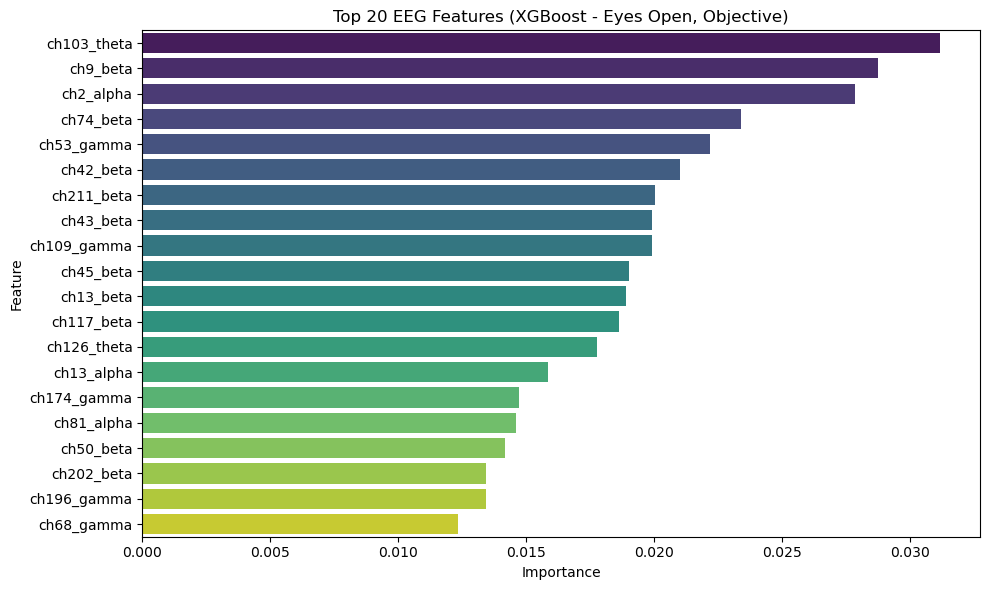

In [72]:
X_list = []
y_list = []

feature_names = []
for band in eeg_bands:
    for ch in range(216):
        feature_names.append(f"ch{ch}_{band}")

pleasant_odors = [2, 4]
unpleasant_odors = [1, 3]


for subject in eeg_cleaned_dataset:
    cond = 'eyes_open'
    
    for odor in pleasant_odors:
        X_pleasant = eeg_cleaned_dataset[subject][cond].get(f'odor_{odor}')
        if X_pleasant is not None:
            for i in range(X_pleasant.shape[2]):
                bp = compute_band_power(X_pleasant[:, :, i:i+1])
                features = []
                for band in eeg_bands:
                    features.extend(bp[band][:, 0])
                X_list.append(features)
                y_list.append(1)

    for odor in unpleasant_odors:
        X_unpleasant = eeg_cleaned_dataset[subject][cond].get(f'odor_{odor}')
        if X_unpleasant is not None:
            for i in range(X_unpleasant.shape[2]):
                bp = compute_band_power(X_unpleasant[:, :, i:i+1])
                features = []
                for band in eeg_bands:
                    features.extend(bp[band][:, 0])
                X_list.append(features)
                y_list.append(0)


X = np.array(X_list)
y = np.array(y_list)


model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
model.fit(X, y)

# Plot top 20 most important features
importances = model.feature_importances_
top_idx = np.argsort(importances)[::-1][:20]

top_features = pd.DataFrame({
    "Feature": [feature_names[i] for i in top_idx],
    "Importance": importances[top_idx]
})

plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, x="Importance", y="Feature", palette="viridis")
plt.title("Top 20 EEG Features (XGBoost - Eyes Open, Objective)")
plt.tight_layout()
plt.show()


In [ ]:
# 1. Most important band: Beta
# 10 out of the top 20 features are beta band.
# Found in channels like ch9_beta, ch74_beta, ch42_beta, ch211_beta.
# Beta activity is often associated with sensorimotor processing, attention.

# 2. Strong frontal and central channel involvement
# Channels like ch2, ch13, ch42, and ch74 (based on standard 256-channel layouts) are frontal-central areas.
# This suggests the model is picking up on emotion-related and cognitive evaluation patterns.

# 3. Alpha and theta bands also contribute
# ch2_alpha, ch13_alpha, ch126_theta, ch103_theta show up in top 10.
# Alpha reflects relaxation/valence processing, theta links to emotional and attentional engagement.

# 4. Gamma is present but less dominant
# 4 gamma features appear — this may reflect high-level sensory integration, but with lower model weight.

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


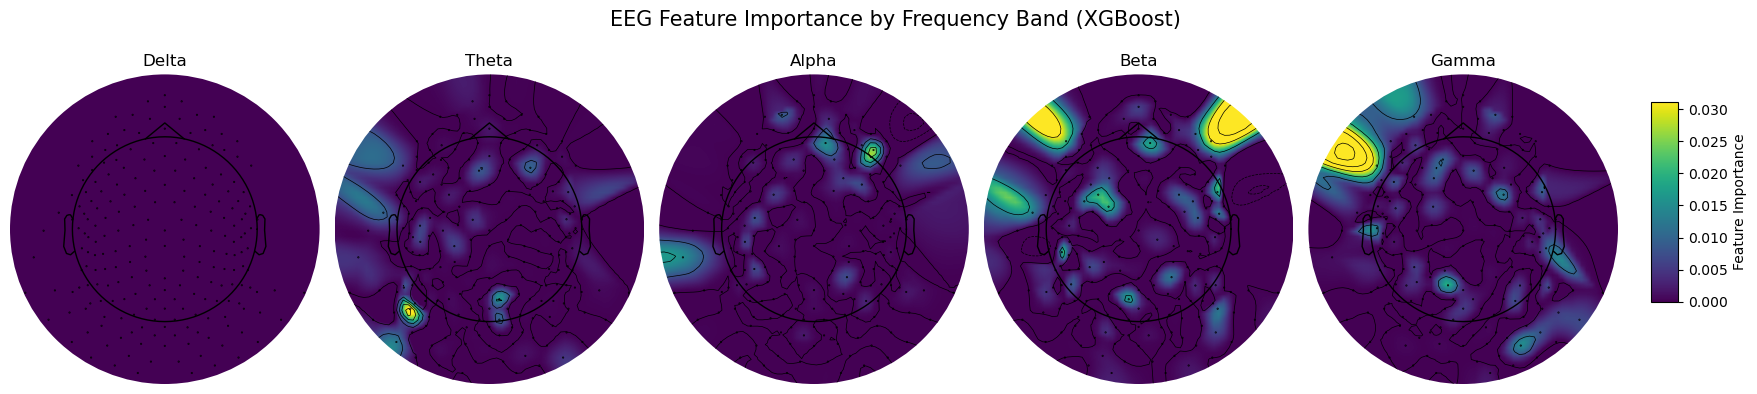

In [75]:

fig, axes = plt.subplots(1, 5, figsize=(18, 4))
vlim_max = max(np.max(np.abs(v)) for v in band_values.values())

for i, band in enumerate(['delta', 'theta', 'alpha', 'beta', 'gamma']):
    ax = axes[i]
    plot_topomap(
        band_values[band],
        pos=info,
        axes=ax,
        cmap='viridis',
        contours=6,
        sphere=0.07,
        vlim=(0, vlim_max),
        show=False
    )
    ax.set_title(f"{band.capitalize()}", fontsize=12)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
norm = plt.Normalize(vmin=0, vmax=vlim_max)
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
fig.colorbar(sm, cax=cbar_ax, label='Feature Importance')

fig.suptitle("EEG Feature Importance by Frequency Band (XGBoost)", fontsize=15)
plt.tight_layout(rect=[0, 0, 0.91, 0.95])
plt.show()


In [ ]:
# EEG beta and alpha bands in central/parietal/frontal regions are key for pleasantness.
# Theta and Gamma contributes subtly but meaningfully.

In [97]:
beta_band = (13, 30)
pleasant_odors = [2, 4]
unpleasant_odors = [1, 3]

def compute_beta_power(X, sfreq=250):
    n_channels = X.shape[1]
    n_trials = X.shape[2]
    power = np.zeros((n_channels, n_trials))
    for i in range(n_trials):
        for ch in range(n_channels):
            f, psd = welch(X[:, ch, i], fs=sfreq, nperseg=128)
            mask = (f >= beta_band[0]) & (f <= beta_band[1])
            power[ch, i] = np.mean(psd[mask])
    return power

def get_channel_positions(info):
    xyz = np.array([ch['loc'][:3] for ch in info['chs']])
    labels = [ch['ch_name'] for ch in info['chs']]
    return xyz, labels

def plot_3d_scalp_map(values, info, title="3D Scalp Map"):
    xyz, labels = get_channel_positions(info)
    fig = go.Figure(data=[
        go.Scatter3d(
            x=xyz[:, 0], y=xyz[:, 1], z=xyz[:, 2],
            mode='markers+text',
            marker=dict(
                size=6,
                color=values,
                colorscale='RdBu',
                colorbar=dict(title='T-value'),
                showscale=True,
                opacity=0.9
            ),
            text=labels,
            hoverinfo='text'
        )
    ])
    fig.update_layout(
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False),
            aspectmode='data'
        ),
        title=title,
        margin=dict(l=0, r=0, t=40, b=0)
    )
    fig.show()


for subject in eeg_cleaned_dataset:
    data = eeg_cleaned_dataset[subject]['eyes_open']

    pleasant = [data[f'odor_{i}'] for i in pleasant_odors if f'odor_{i}' in data]
    unpleasant = [data[f'odor_{i}'] for i in unpleasant_odors if f'odor_{i}' in data]
    if not pleasant or not unpleasant:
        continue

    X_pleasant = np.concatenate(pleasant, axis=2)
    X_unpleasant = np.concatenate(unpleasant, axis=2)

    power_pleasant = compute_beta_power(X_pleasant)
    power_unpleasant = compute_beta_power(X_unpleasant)

    t_vals, p_vals = stats.ttest_ind(power_pleasant, power_unpleasant, axis=1, equal_var=False)

    plot_3d_scalp_map(t_vals, info, title=f"{subject} — Beta T-values (Pleasant vs Unpleasant, Eyes Open)")


In [ ]:
# t-value per channel tells how different the beta-band power is between pleasant and unpleasant odors — at that electrode.
# Negative t-values: stronger for unpleasant odors.
# Positive t-values: stronger for pleasant odors.

# very clear subjective differences.

In [ ]:
# * 1.EEG-Based Personal Preference Prediction
# Goal: predict whether a person will like a new fragrance based on their brain response.
# Have models predict pleasantness for new (unseen) odors from brain signals.
# Business impact: Develop "smart scent testers" for personalized marketing.

# * 2.Subject Clustering - Fragrance Profiling
# Goal: discover neurotypes that respond similarly to certain fragrance styles.
# Cluster users based on their EEG response profiles across odors (extend to different ages, genders, races)
# Match those clusters to olfactory notes (i.e floral, spicy, herbal).
# Use this to target fragrance launches to specific user segments or countries.

# ** 3.Odor Space Mapping from EEG
# Goal: build a perceptual map of fragrances based on how brains respond (more calm, more attentive, more sleepy, happier, etc.), not just ratings.
# Use multidimensional scaling or t-SNE on EEG feature differences across odor elements.
# Guide to funtional fragrance design.

# *** 4.Identify Neural Markers of 'Signature' Scents (memorable)
# Goal: identify the most “long lasting brain-reactive” fragrance, even if people aren’t consciously aware of it.
# Explore "implicit emotional" impact of odors (people may not be fully aware at first but leave an impacting memory - lead to good sale)
# 1) Strongly modulate EEG power (spikes in frontal alpha, parietal gamma, etc.) - intensity
# 2) Actively reponsive memory encoding, based on arousal-related EEG patterns - brain region related to memory

# Odors that don’t get rated highly, but trigger strong unconscious brain responses
# Scents that elicit brain state changes (e.g., calmness, alertness) — useful in wellness, emotions and clinical uses. 

# ** 5. For a given fragrance (i.e rosewater), how intense should it be to maximize its desired brain impact (pleasure, memorability, calmness)?
# Design a experiment for dose–response relationship between odor concentration and EEG-based emotional markers.

